In [18]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pickle
import random as random
import pickle as cPickle
from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
%matplotlib inline

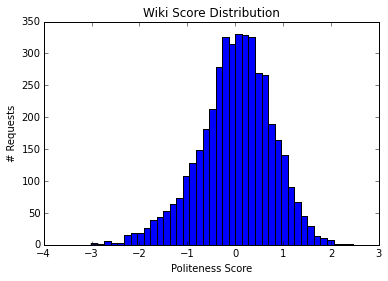

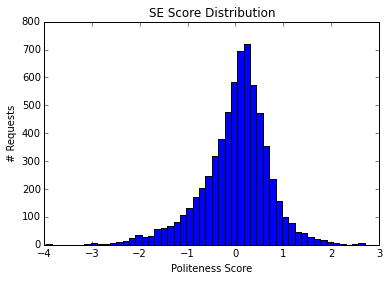

In [3]:
def plotHistogram(inputCsv, title, b=20):
    scores = []
    with open(inputCsv, 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        spamreader.next()
        for row in spamreader:
            scores.append(float(row[-1]))
    
    plt.clf()
    plt.hist(scores, bins=b)
    plt.title(title)
    plt.xlabel("Politeness Score")
    plt.ylabel("# Requests")
    plt.show()
    
plotHistogram('data/wikipedia.annotated.csv', "Wiki Score Distribution", 40)
plotHistogram('data/stack-exchange.annotated.csv', "SE Score Distribution", 50)

In [7]:
PATH = 'data/reddit/pickleFiles/'
DATA_FILES = ['reddit_data.pickle']
redditData = pickle.load(open(PATH + DATA_FILES[0], "rb" ))
print redditData.keys()

redditDics = {}
for key, val in redditData.iteritems():
    print key
    print len(val[1])
    new = []
    count = 0
    for v in val[1]:
        dic = {}
        if v['before']=='[deleted]' or v['before']=='':
            count += 1
            continue
        dic['Request'] = v['before'].encode('ascii','ignore') + ' ' + v['current'].encode('ascii','ignore')
        new.append(dic)
    redditDics[key] = new


['unitedkingdom', 'usnews', 'unitedstates', 'ukpolitics', 'uspolitics', 'uknews']
unitedkingdom
1201
usnews
820
unitedstates
9
ukpolitics
1201
uspolitics
875
uknews
79


In [8]:
print redditDics['unitedstates']

[{'Request': 'no, you wont get killed.. Where are you planning on traveling?'}, {'Request': "But so far as i know you won't be killed because you are Asian in most of the US. Maybe somewhere in the deep south?"}, {'Request': 'http://youtu.be/5hfYJsQAhl0 What part of my post in incorrect?'}, {'Request': 'Further, your point about babies is bizarre. Do children not have a right to be counted in the population?'}, {'Request': "Thank you. I've found this: https://answers.yahoo.com/question/index?qid=20131204014742AAirvOr\n\nApparently this claim was some kind of hoax"}, {'Request': 'Canada. Pueto rico? '}, {'Request': 'Idaho. When was the last time you heard of anything happening in Idaho?'}, {'Request': 'Thanks Chillhardy! What about Maryland?'}]


In [9]:
from features.vectorizer import PolitenessFeatureVectorizer
def score(request):
    """
    :param request - The request document to score
    :type request - dict with 'sentences' and 'parses' field
        sample (taken from test_documents.py)--
        {
            'sentences': [
                "Have you found the answer for your question?", 
                "If yes would you please share it?"
            ],
            'parses': [
                ["csubj(found-3, Have-1)", "dobj(Have-1, you-2)", "root(ROOT-0, found-3)", "det(answer-5, the-4)", "dobj(found-3, answer-5)", "poss(question-8, your-7)", "prep_for(found-3, question-8)"], 
                ["prep_if(would-3, yes-2)", "root(ROOT-0, would-3)", "nsubj(would-3, you-4)", "ccomp(would-3, please-5)", "nsubj(it-7, share-6)", "xcomp(please-5, it-7)"]
            ]
        } 

    returns class probabilities as a dict
        {
            'polite': float, 
            'impolite': float
        }
    """
    # vectorizer returns {feature-name: value} dict
    features = vectorizer.features(request)
    fv = [features[f] for f in sorted(features.iterkeys())]
    # Single-row sparse matrix
    X = csr_matrix(np.asarray([fv]))
    probs = clf.predict_proba(X)
    # Massage return format
    probs = {"polite": probs[0][1], "impolite": probs[0][0]}
    return probs

In [10]:
from nltk.tokenize import sent_tokenize
for text in redditDics['unitedstates']:
    doc={}
    doc['sentences']=sent_tokenize(text['Request'])
    print doc
#     probs = score(doc)

#     print "===================="
#     print "Text: ", doc['text']
#     print "\tP(polite) = %.3f" % probs['polite']
#     print "\tP(impolite) = %.3f" % probs['impolite']
#     print "\n"

{'sentences': ['no, you wont get killed.. Where are you planning on traveling?']}
{'sentences': ["But so far as i know you won't be killed because you are Asian in most of the US.", 'Maybe somewhere in the deep south?']}
{'sentences': ['http://youtu.be/5hfYJsQAhl0 What part of my post in incorrect?']}
{'sentences': ['Further, your point about babies is bizarre.', 'Do children not have a right to be counted in the population?']}
{'sentences': ['Thank you.', "I've found this: https://answers.yahoo.com/question/index?qid=20131204014742AAirvOr\n\nApparently this claim was some kind of hoax"]}
{'sentences': ['Canada.', 'Pueto rico? ']}
{'sentences': ['Idaho.', 'When was the last time you heard of anything happening in Idaho?']}
{'sentences': ['Thanks Chillhardy!', 'What about Maryland?']}


In [12]:
print stack_data['7701271'].keys()

['parses', 'Score3', 'Request', 'Community', 'Score4', 'Score5', 'score', 'Score1', 'Score2', 'sentences', 'TurkId2', 'TurkId3', 'TurkId1', 'Id', 'TurkId4', 'TurkId5']


In [21]:
def train_svm(documents, ntesting=500):
    """
    :param documents- politeness-annotated training data
    :type documents- list of dicts
        each document must be preprocessed and
        'sentences' and 'parses' and 'score' fields.

    :param ntesting- number of docs to reserve for testing
    :type ntesting- int

    returns fitted SVC, which can be serialized using cPickle
    """
    # Generate and persist list of unigrams, bigrams  
    PolitenessFeatureVectorizer.generate_bow_features(documents)

    # For good luck
    random.shuffle(documents)
    testing = documents[-ntesting:]
    documents = documents[:-ntesting]

    # SAVE FOR NOW
    #cPickle.dump(testing, open("testing-data.p", 'w'))

    X, y = documents2feature_vectors(documents)
    Xtest, ytest = documents2feature_vectors(testing)

    print "Fitting"
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    clf.fit(X, y)

    # Test
    y_pred = clf.predict(Xtest)
    
    print(classification_report(ytest, y_pred))

    return X,y,Xtest, ytest, clf


def documents2feature_vectors(documents):
    vectorizer = PolitenessFeatureVectorizer()
    fks = False
    X, y = [], []
    for d in documents:
        fs = vectorizer.features(d)
        if not fks:
            fks = sorted(fs.keys())
        fv = [fs[f] for f in fks]
        # If politeness score > 0.0, 
        # the doc is polite, class=1
        l = 1 if d['score'] > 0.0 else 0
        X.append(fv)
        y.append(l)
    X = csr_matrix(np.asarray(X))
    y = np.asarray(y)
    return X, y



In [34]:

stack_data=pickle.load(open('data/wiki_parsed.p'))

In [35]:
documents=stack_data.values() 
PolitenessFeatureVectorizer.generate_bow_features(documents)

ntesting=len(documents)/10
# For good luck
random.shuffle(documents)
testing = documents[-ntesting:]
documents = documents[:-ntesting]

# SAVE FOR NOW
#cPickle.dump(testing, open("testing-data.p", 'w'))

X, y = documents2feature_vectors(documents)
Xtest, ytest = documents2feature_vectors(testing)

print "Fitting"
clf = svm.SVC(C=0.02, kernel='linear', probability=True)
clf.fit(X, y)

# Test
y_pred = clf.predict(Xtest)

print(classification_report(ytest, y_pred))

    


Fitting
             precision    recall  f1-score   support

          0       0.75      0.71      0.73       224
          1       0.71      0.74      0.73       211

avg / total       0.73      0.73      0.73       435



In [36]:
clf.score(Xtest, ytest)

0.72873563218390802

In [41]:
print type(X[0])
print "zero", X[1]

<class 'scipy.sparse.csr.csr_matrix'>
zero   (0, 37)	1
  (0, 207)	1
  (0, 371)	1
  (0, 585)	1
  (0, 616)	1
  (0, 619)	1
  (0, 628)	1
  (0, 653)	1
  (0, 696)	1
  (0, 703)	1
  (0, 714)	1
  (0, 724)	1
  (0, 733)	1
  (0, 744)	1
  (0, 815)	1
  (0, 896)	1
  (0, 905)	1
  (0, 920)	1
  (0, 983)	1
  (0, 1134)	1
  (0, 1202)	1
  (0, 1208)	1
  (0, 1212)	1
